### NOTES:
- I messed up in Gdrive by deleting the " in the Cincinnati SERVICE_NAME columns in the Master Sheet, so you need to also delete to .map(lambda x: str(x).strip('"') the column before mapping to the new categories

In [78]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

%matplotlib inline

In [79]:
!ls /Users/ChrisD/Documents/UCBerkeleyMIDS/W210/Capstone_Project/Data

BR_categories_grouped.csv           US_BATON_ROUGE_trainingdata 2.tsv
BR_comments_cut.csv                 US_BATON_ROUGE_trainingdata 3.tsv
Bloomington_311.csv                 US_CHICAGO_trainingdata.tsv
CHI_categories_grouped.csv          US_CHI_BR_IE_trainingdata.tsv
CIN_categories_grouped.csv          chi_br_IE_train_1.tsv
Complaint_types - Master_sheet.tsv  chicago_comments_cut.csv
Complaint_types_Master_sheet_v2.tsv ireland_fix_my_street.csv
Complaint_types_Master_sheet_v3.tsv


In [80]:
PATH='~/Documents/UCBerkeleyMIDS/W210/Capstone_Project/Data'
#os.chdir(path)

# Create dictionary for reclassifying categories

"Complaint_types - Master_sheet.tsv" is a table of each category-subcategory used in the Chicago, Baton Rouge, Cinncinnati, and other files along with their corresponding MAIN and SUB category that we will be using for training.

In [92]:
df_reclass=pd.read_csv(PATH+'/Complaint_types_Master_sheet_v3.tsv',sep='\t')

#replace and drop columns with no CATEGORY_MAIN
df_reclass['CATEGORY_MAIN'].replace('', np.nan, inplace=True)
df_reclass['CATEGORY_MAIN'].map(lambda x: str(x).strip(' '))
df_reclass.dropna(subset=['CATEGORY_MAIN'], inplace=True)

df_reclass['CATEGORY_MAIN']=df_reclass['CATEGORY_MAIN'].map(lambda x:x.upper())
df_reclass['CATEGORY_SUB']=df_reclass['CATEGORY_SUB'].map(lambda x:x.upper())

Fields:
    - CITY : which city's 311 program
    - DEPT_311: second-most specific categorization for each complaint
    - CODE_311: most specific categorization for each complaint 
    - COUNT: How many complaints of each CODE_311
    - CATEGORY_MAIN: our general categorization
    - CATEGORY_SUB: our specific categorization
    
We are only training on two levels of categorization. The initial plan is focus on the higher level categorization, so that complaints can get to the correct department. Subcategorization can either be done as a second classification process within each category or done all at once in the main categorization process.

In [93]:
display(df_reclass.head(2))
display(df_reclass.CATEGORY_MAIN.unique())

,CITY,DEPT_311,CODE_311,COUNT,CATEGORY_MAIN,CATEGORY_SUB
0,US_CHICAGO,health_environment,abandoned site,87.0,ENVIRONMENT,ENVIRONMENT_ABANDONED_SITE
1,US_CHICAGO,health_environment,air pollution work order,17839.0,ENVIRONMENT,ENVIRONMENT_AIR_POLLUTION


array(['ENVIRONMENT', 'PLANNING', 'PUBLIC_ORDER', 'INFRASTRUCTURE',
       'HOUSING', 'GOVERNANCE', 'VANDALISM', 'STREET', 'FIRE',
       'PUBLIC_HEALTH', 'PUBLIC_TRANSIT', 'GENERAL'], dtype=object)

The counts below are unedited, precleaned data

In [94]:
display(df_reclass.groupby(['CATEGORY_MAIN']).sum())
df_reclass.groupby(['CATEGORY_MAIN','CATEGORY_SUB']).sum()

,COUNT
CATEGORY_MAIN,
ENVIRONMENT,627145.0
FIRE,14108.0
GENERAL,0.0
GOVERNANCE,11038.0
HOUSING,59921.0
INFRASTRUCTURE,40180.0
PLANNING,23403.0
PUBLIC_HEALTH,9032.0
PUBLIC_ORDER,8815.0


COUNT
CATEGORY_MAIN  CATEGORY_SUB                                  
ENVIRONMENT    ENVIRONEMNT_DEAD_ANIMAL                  270.0
               ENVIRONMENT_ABANDONED_SITE              3405.0
               ENVIRONMENT_ABANDONED_VEHICLE          16631.0
               ENVIRONMENT_AIR_POLLUTION              17905.0
               ENVIRONMENT_ASBESTOS                    2737.0
               ENVIRONMENT_DEAD_ANIMAL                11709.0
               ENVIRONMENT_DUMPING                    16927.0
               ENVIRONMENT_GARBAGE_COLLECTION        393656.0
               ENVIRONMENT_GENERAL                     4126.0
               ENVIRONMENT_HAZARDOUS_MATERIAL          5827.0
               ENVIRONMENT_LITTER                     15398.0
               ENVIRONMENT_OVERGROWTH                 67864.0
               ENVIRONMENT_RECYCLING                  70641.0
               ENVIRONMENT_WATER_POLLUTION               34.0
               ENVIRONNMENT_HAZARDOUS_MATERIAL           15.0
FIRE           FIRE_CODE_VIOLATION                        7.0
               FIRE_EQUIPMENT_BROKEN                    665.0
               FIRE_GENERAL                           13367.0
               FIRE_RISKS                                69.0
GENERAL        GENERAL_EMERGENCY                          0.0
               GENERAL_INQUIRY                            0.0
GOVERNANCE     GOVERANANCE_GENERAL                       50.0
               GOVERNANCE_COMMUNITY                      66.0
               GOVERNANCE_GENERAL                      2977.0
               GOVERNANCE_IT                            118.0
               GOVERNANCE_PARKS_AND_REC                 855.0
               GOVERNANCE_SIGNAGE                      6972.0
HOUSING        HOUSING_FLOODING                           0.0
               HOUSING_GENERAL                        42523.0
               HOUSING_HEALTH_CODE                     7944.0
               HOUSING_MOLD                            5462.0
               HOUSING_PESTS                            164.0
               HOUSING_SAFETY                          3828.0
INFRASTRUCTURE INFRASTRUCTURE_GENERAL                 30764.0
               INFRASTRUCTURE_WATER                    5602.0
               INFRASTRUCTURE_WATER_REPAIR             3814.0
PLANNING       PLANNING_CONSTRUCTION                    202.0
               PLANNING_GENERAL                       18768.0
               PLANNING_UNSAFE_ENVIRONMENT             4433.0
PUBLIC_HEALTH  PUBLICHEALTH_ANIMAL                      216.0
               PUBLICHEALTH_ANIMAL_FECES                711.0
               PUBLICHEALTH_GENERAL                    2191.0
               PUBLICHEALTH_PESTS                      5854.0
               PUBLICHEALTH_PUBLIC_BUILDING_HYGIENE      20.0
               PUBLICHEALTH_SCHOOL_HYGIENE               40.0
PUBLIC_ORDER   PUBLICORDER_GENERAL                       77.0
               PUBLICORDER_NOISE_COMPLAINT             8738.0
PUBLIC_TRANSIT PUBLICTRANSIT_BUS_SERVICE                 29.0
STREET         STREET_CLEANING                         1661.0
               STREET_GENERAL                          2826.0
               STREET_LIGHTING                        12870.0
               STREET_PARKING                          2058.0
               STREET_REPAIR                          50882.0
               STREET_SEWAR                            4706.0
               STREET_SIDEWALK                         5483.0
               STREET_SLIPPERY                         8370.0
               STREET_URGENT_REPAIR                   16879.0
VANDALISM      VANDALISM_GENERAL                        429.0
               VANDALISM_GRAFFITI                     13861.0

# Support functions

In [95]:
def lookup_311_code(dic,city,dept_311,code_311):
    
    # dic= dictionary of {(city,dept_311,code_311): (MAIN,SUB)}
    
    vals=dic.get((city,dept_311,code_311))
    
    if vals is not None:
        return vals
    else:
        return ('unknown','unknown')


## Create the dictionary

We use the df_reclass dataframe to build a dictionary of DEPT_311 and CODE_311 conversions for each city 

In [96]:
reclass_dict=defaultdict(dict)


for index,row in df_reclass.iterrows():

    reclass_dict[(row['CITY'],row['DEPT_311'],row['CODE_311'])]=(row['CATEGORY_MAIN'],row['CATEGORY_SUB'])

In [97]:
reclass_dict

defaultdict(dict,
            {('IRELAND', 'GENERAL', 'Broken Street Lights'): ('STREET',
              'STREET_LIGHTING'),
             ('IRELAND', 'GENERAL', 'Broken Street Paths'): ('STREET',
              'STREET_REPAIR'),
             ('IRELAND', 'GENERAL', 'Broken street lighting'): ('STREET',
              'STREET_LIGHTING'),
             ('IRELAND', 'GENERAL', 'Broken street path'): ('STREET',
              'STREET_REPAIR'),
             ('IRELAND', 'GENERAL', 'Drainage Problems'): ('INFRASTRUCTURE',
              'INFRASTRUCTURE_GENERAL'),
             ('IRELAND', 'GENERAL', 'Graffiti'): ('VANDALISM',
              'VANDALISM_GRAFFITI'),
             ('IRELAND', 'GENERAL', 'Leaks and Drainage'): ('INFRASTRUCTURE',
              'INFRASTRUCTURE_GENERAL'),
             ('IRELAND',
              'GENERAL',
              'Litter and Illegal Dumping'): ('ENVIRONMENT', 'ENVIRONMENT_DUMPING'),
             ('IRELAND', 'GENERAL', 'Road Maintenance/Potholes'): ('STREET',
              

# DATA CLEAN AND JOIN

We can either import the full dataset and trim it down, or import the already trimmed dataframe 

In [43]:
!ls /Users/ChrisD/Documents/UCBerkeleyMIDS/W210/Capstone_Project/Data

BR_categories_grouped.csv           Complaint_types - Master_sheet.tsv
BR_comments_cut.csv                 Complaint_types_Master_sheet_v2.tsv
CHI_categories_grouped.csv          chicago_comments_cut.csv
CIN_categories_grouped.csv          ireland_fix_my_street.csv


## Chicago

In [98]:
df_chicago=pd.read_csv(PATH+'/chicago_comments_cut.csv', sep='\t')
df_chicago.drop(labels=['Unnamed: 0','INSPECTOR','locality'],axis=1,inplace=True)
df_chicago.head(2)

,COMPLAINT ID,DATA SOURCE,COMPLAINT TYPE,COMPLAINT DATE,COMPLAINT DETAIL,INSPECTION LOG
0,1725,HISTORIC DEPT. OF ENVIRONMENT,permits issued by doe work order,10/03/2011,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...,[INSPECTION LOG #: 1723 03-OCT-11 18:55:00] TH...
1,600301602,DEPT. OF PUBLIC HEALTH,illegal dumping work order,07/14/2017,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...,[INSPECTION LOG #: 3439804 14-JUL-17 09:45:00]...


In [99]:
df_chicago['DATA SOURCE']='health_environment'
df_chicago['CITY']='US_CHICAGO'
df_chicago['COMPLAINT ID']= df_chicago['CITY'] + '_' + df_chicago['COMPLAINT ID']
df_chicago.columns=['COMPLAINT_ID','DEPT_311','CODE_311','COMPLAINT DATE','COMPLAINT_1','COMPLAINT_2','CITY']
df_chicago=df_chicago[['COMPLAINT_ID','CITY','DEPT_311','CODE_311','COMPLAINT_1','COMPLAINT_2','COMPLAINT DATE']]
df_chicago.head(2)

,COMPLAINT_ID,CITY,DEPT_311,CODE_311,COMPLAINT_1,COMPLAINT_2,COMPLAINT DATE
0,US_CHICAGO_1725,US_CHICAGO,health_environment,permits issued by doe work order,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...,[INSPECTION LOG #: 1723 03-OCT-11 18:55:00] TH...,10/03/2011
1,US_CHICAGO_600301602,US_CHICAGO,health_environment,illegal dumping work order,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...,[INSPECTION LOG #: 3439804 14-JUL-17 09:45:00]...,07/14/2017


In [100]:
df_chicago['CATEGORY_MAIN']=df_chicago.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[0],axis=1)



In [101]:
df_chicago['CATEGORY_SUB']=df_chicago.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[1],axis=1)



In [102]:
df_chicago.to_csv(PATH+'/US_CHICAGO_trainingdata.tsv',sep='\t')


## Baton Rouge

In [103]:
df_batonrouge=pd.read_csv(PATH+'/BR_comments_cut.csv')
display(df_batonrouge.head(2))

df_batonrouge.drop(labels=['Unnamed: 0','DEPARTMENT','DIVISION','GEOLOCATION'],axis=1,inplace=True)
df_batonrouge['CITY']='US_BATON_ROUGE'
df_batonrouge.columns=['COMPLAINT_ID','COMPLAINT DATE','DEPT_311','CODE_311','COMPLAINT_1','CITY']
df_batonrouge['COMPLAINT_ID']=df_batonrouge['CITY']+ '_' + df_batonrouge['COMPLAINT_ID'].map(str)
df_batonrouge['COMPLAINT_2']=None
df_batonrouge=df_batonrouge[['COMPLAINT_ID','CITY','DEPT_311','CODE_311','COMPLAINT_1','COMPLAINT_2','COMPLAINT DATE']]
df_batonrouge.head(2)

,Unnamed: 0,SERVICE REQUEST ID,CREATE DATE,PARENT TYPE,TYPE,DEPARTMENT,DIVISION,COMMENTS,GEOLOCATION
0,0,220943,03/22/2016 04:40:00 PM,ROAD MAINTENANCE ISSUES,POTHOLE,MAINTENANCE,STREET MAINTENANCE,POTHOLE ON THE SW CORNER OF HILMONT AND SPRING...,"(30.342981, -91.114136)"
1,1,248677,07/27/2016 02:45:00 PM,STREET/TRAFFIC ISSUES,ROAD STRIPING NEEDED,TRANSPORTATION AND DEVELOPMENT,TRAFFIC ENGINEERING,STREET NEEDS TO BE RE STRIPED AT THE CORNER SO...,"(30.439724, -91.174988)"


,COMPLAINT_ID,CITY,DEPT_311,CODE_311,COMPLAINT_1,COMPLAINT_2,COMPLAINT DATE
0,US_BATON_ROUGE_220943,US_BATON_ROUGE,ROAD MAINTENANCE ISSUES,POTHOLE,POTHOLE ON THE SW CORNER OF HILMONT AND SPRING...,None,03/22/2016 04:40:00 PM
1,US_BATON_ROUGE_248677,US_BATON_ROUGE,STREET/TRAFFIC ISSUES,ROAD STRIPING NEEDED,STREET NEEDS TO BE RE STRIPED AT THE CORNER SO...,None,07/27/2016 02:45:00 PM


In [104]:
df_batonrouge['CATEGORY_MAIN']=df_batonrouge.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[0],axis=1)


In [105]:
df_batonrouge['CATEGORY_SUB']=df_batonrouge.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[1],axis=1)

df_batonrouge.head(2)

,COMPLAINT_ID,CITY,DEPT_311,CODE_311,COMPLAINT_1,COMPLAINT_2,COMPLAINT DATE,CATEGORY_MAIN,CATEGORY_SUB
0,US_BATON_ROUGE_220943,US_BATON_ROUGE,ROAD MAINTENANCE ISSUES,POTHOLE,POTHOLE ON THE SW CORNER OF HILMONT AND SPRING...,None,03/22/2016 04:40:00 PM,STREET,STREET_REPAIR
1,US_BATON_ROUGE_248677,US_BATON_ROUGE,STREET/TRAFFIC ISSUES,ROAD STRIPING NEEDED,STREET NEEDS TO BE RE STRIPED AT THE CORNER SO...,None,07/27/2016 02:45:00 PM,STREET,STREET_REPAIR


In [106]:
df_batonrouge.to_csv(PATH+'/US_BATON_ROUGE_trainingdata.tsv',sep='\t')

# IRELAND

In [107]:
df_IE=pd.read_csv(PATH+'/ireland_fix_my_street.csv')
df_IE.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
display(df_IE.head(2))
df_IE['COMPLAINT DATE']='01/01/2018'
df_IE['CITY']='IRELAND'
df_IE['DEPT_311']='GENERAL'
df_IE=df_IE[['COMPLAINT_ID','CITY','DEPT_311','CODE_311','COMPLAINT_1','COMPLAINT_2','COMPLAINT DATE']]

,COMPLAINT_ID,CODE_311,COMPLAINT_1,COMPLAINT_2
0,ireland_100,Road or path defects,Potholes in Allenwood South,"Hi, I live in Allenwood South (L70044), my hou..."
1,ireland_10000,Street Lighting,Street Light,Street light not working


In [108]:
df_IE.head()

,COMPLAINT_ID,CITY,DEPT_311,CODE_311,COMPLAINT_1,COMPLAINT_2,COMPLAINT DATE
0,ireland_100,IRELAND,GENERAL,Road or path defects,Potholes in Allenwood South,"Hi, I live in Allenwood South (L70044), my hou...",01/01/2018
1,ireland_10000,IRELAND,GENERAL,Street Lighting,Street Light,Street light not working,01/01/2018
2,ireland_10001,IRELAND,GENERAL,Tree and Grass Maintenance,Ditch removal,Ditch trees and brambles recently removed by t...,01/01/2018
3,ireland_10002,IRELAND,GENERAL,Street Lighting,Street Light,Street light not working,01/01/2018
4,ireland_10003,IRELAND,GENERAL,Street Lighting,Street Light,Street light not working at this location,01/01/2018


In [109]:
df_IE['CATEGORY_MAIN']=df_IE.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[0],axis=1)

In [110]:
df_IE['CATEGORY_SUB']=df_IE.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[1],axis=1)

df_IE.head(2)

,COMPLAINT_ID,CITY,DEPT_311,CODE_311,COMPLAINT_1,COMPLAINT_2,COMPLAINT DATE,CATEGORY_MAIN,CATEGORY_SUB
0,ireland_100,IRELAND,GENERAL,Road or path defects,Potholes in Allenwood South,"Hi, I live in Allenwood South (L70044), my hou...",01/01/2018,STREET,STREET_REPAIR
1,ireland_10000,IRELAND,GENERAL,Street Lighting,Street Light,Street light not working,01/01/2018,STREET,STREET_LIGHTING


In [111]:
df_IE.to_csv(PATH+'/IRELAND_trainingdata.tsv',sep='\t')

# Cincinnati

In [137]:
df_CIN=pd.read_csv(PATH+'/CIN_comments_cut.csv',sep='\t')

df_CIN['CITY']='US_CINCINNATI'
df_CIN['COMPLAINT_ID']=df_CIN['CITY']+ '_' + df_CIN['SERVICE_REQUEST_ID'].map(str)
df_CIN.drop(labels=['Unnamed: 0','STATUS','STATUS_NOTES','GPS','SERVICE_REQUEST_ID','SERVICE_CODE'],axis=1,inplace=True)

df_CIN.columns=['CITY', 'CODE_311', 'COMPLAINT_1', 'DEPT_311','COMPLAINT DATE', 'COMPLAINT_ID']
df_CIN['COMPLAINT_2']=np.nan
df_CIN['CODE_311']=df_CIN['CODE_311'].map(lambda x: str(x).strip('"'))



In [139]:
df_CIN.columns

Index(['CITY', 'CODE_311', 'COMPLAINT_1', 'DEPT_311', 'COMPLAINT DATE',
       'COMPLAINT_ID', 'COMPLAINT_2'],
      dtype='object')

In [140]:
df_CIN.head(2)

,CITY,CODE_311,COMPLAINT_1,DEPT_311,COMPLAINT DATE,COMPLAINT_ID,COMPLAINT_2
0,US_CINCINNATI,"Default, police (and junk veh)","""Request entered through the Web. Refer to Int...",Police Department,08/26/2018,US_CINCINNATI_SR18080929,NaN
1,US_CINCINNATI,"Tires, Special Collection","""Request entered through the Web. Refer to Int...",Public Services,08/26/2018,US_CINCINNATI_SR18080942,NaN


In [141]:
df_CIN['CATEGORY_MAIN']=df_CIN.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[0],axis=1)

In [142]:
df_CIN['CATEGORY_SUB']=df_CIN.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[1],axis=1)

In [168]:
df_CIN[df_CIN['CATEGORY_MAIN']!='unknown'].to_csv(PATH+'/US_CINCINNATI_trainingdata.tsv',sep='\t')

In [169]:
df_CIN=df_CIN[df_CIN['CATEGORY_MAIN']!='unknown']

# Bloomington

In [151]:
df_Bloom=pd.read_csv(PATH+'/Bloomington_311.csv')
#df_Bloom.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df_Bloom['service_subtype']='general'
df_Bloom.drop(labels=['updated_datetime','closed_date','status','source','agency_responsible','address','lat','long'],axis=1,inplace=True)

df_Bloom['CITY']='US_BLOOMINGTON'
df_Bloom['COMPLAINT_ID']=df_Bloom['CITY']+ '_' + df_Bloom['service_request_id'].map(str)
df_Bloom.drop(labels=['service_request_id'],axis=1,inplace=True)
df_Bloom.columns=['COMPLAINT DATE','DEPT_311','CODE_311','COMPLAINT_1','CITY','COMPLAINT_ID']
df_Bloom['COMPLAINT_2']=np.nan
display(df_Bloom.head(2))

,COMPLAINT DATE,DEPT_311,CODE_311,COMPLAINT_1,CITY,COMPLAINT_ID,COMPLAINT_2
0,2011-06-27T04:00:00-04:00,Recycling,general,Recycables and non-recycables waste mixed. 949,US_BLOOMINGTON,US_BLOOMINGTON_470,NaN
1,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds.,US_BLOOMINGTON,US_BLOOMINGTON_471,NaN


In [147]:
df_Bloom.head()

,service_request_id,requested_datetime,service_name,service_subtype,description
0,470,2011-06-27T04:00:00-04:00,Recycling,general,Recycables and non-recycables waste mixed. 949
1,471,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds.
2,472,2011-06-27T04:00:00-04:00,Trash,general,Bags/cans must have sticker attached. 956
3,473,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds. Cans over ...
4,474,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds. 948


In [152]:
df_Bloom['CATEGORY_MAIN']=df_Bloom.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[0],axis=1)
print('main complete')
df_Bloom['CATEGORY_SUB']=df_Bloom.apply(lambda x: lookup_311_code(reclass_dict,x.CITY,x.DEPT_311,x.CODE_311)[1],axis=1)


main complete


In [155]:
df_Bloom[df_Bloom['CATEGORY_MAIN']!='unknown'].head()

,COMPLAINT DATE,DEPT_311,CODE_311,COMPLAINT_1,CITY,COMPLAINT_ID,COMPLAINT_2,CATEGORY_MAIN,CATEGORY_SUB
0,2011-06-27T04:00:00-04:00,Recycling,general,Recycables and non-recycables waste mixed. 949,US_BLOOMINGTON,US_BLOOMINGTON_470,NaN,ENVIRONMENT,ENVIRONMENT_RECYCLING
1,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds.,US_BLOOMINGTON,US_BLOOMINGTON_471,NaN,ENVIRONMENT,ENVIRONMENT_GARBAGE_COLLECTION
2,2011-06-27T04:00:00-04:00,Trash,general,Bags/cans must have sticker attached. 956,US_BLOOMINGTON,US_BLOOMINGTON_472,NaN,ENVIRONMENT,ENVIRONMENT_GARBAGE_COLLECTION
3,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds. Cans over ...,US_BLOOMINGTON,US_BLOOMINGTON_473,NaN,ENVIRONMENT,ENVIRONMENT_GARBAGE_COLLECTION
4,2011-06-27T04:00:00-04:00,Trash,general,Exceeds weight Limit of 40 pounds. 948,US_BLOOMINGTON,US_BLOOMINGTON_474,NaN,ENVIRONMENT,ENVIRONMENT_GARBAGE_COLLECTION


- save only the ones that are categorized

In [156]:
df_Bloom['CATEGORY_MAIN'].unique()

array(['ENVIRONMENT', 'unknown', 'STREET', 'GOVERNANCE', 'INFRASTRUCTURE',
       'PUBLIC_HEALTH', 'FIRE', 'VANDALISM', 'PUBLIC_TRANSIT'],
      dtype=object)

In [157]:
df_Bloom[df_Bloom['CATEGORY_MAIN']!='unknown'].to_csv(PATH+'/US_BLOOMINGTON_trainingdata.tsv',sep='\t')

In [158]:
df_Bloom=df_Bloom[df_Bloom['CATEGORY_MAIN']!='unknown']

## COMBINE THEM

In [115]:
display(df_chicago.columns)==display(df_batonrouge.columns)
display(df_IE.columns)==display(df_batonrouge.columns)

Index(['COMPLAINT_ID', 'CITY', 'DEPT_311', 'CODE_311', 'COMPLAINT_1',
       'COMPLAINT_2', 'COMPLAINT DATE', 'CATEGORY_MAIN', 'CATEGORY_SUB'],
      dtype='object')

Index(['COMPLAINT_ID', 'CITY', 'DEPT_311', 'CODE_311', 'COMPLAINT_1',
       'COMPLAINT_2', 'COMPLAINT DATE', 'CATEGORY_MAIN', 'CATEGORY_SUB'],
      dtype='object')

Index(['COMPLAINT_ID', 'CITY', 'DEPT_311', 'CODE_311', 'COMPLAINT_1',
       'COMPLAINT_2', 'COMPLAINT DATE', 'CATEGORY_MAIN', 'CATEGORY_SUB'],
      dtype='object')

Index(['COMPLAINT_ID', 'CITY', 'DEPT_311', 'CODE_311', 'COMPLAINT_1',
       'COMPLAINT_2', 'COMPLAINT DATE', 'CATEGORY_MAIN', 'CATEGORY_SUB'],
      dtype='object')

True

In [182]:
df_combined=pd.concat([df_chicago,df_batonrouge,df_IE,df_CIN,df_Bloom])
df_combined=df_combined[df_combined['CATEGORY_MAIN']!='unknown']

In [183]:
display(df_chicago.shape)
display(df_batonrouge.shape)
display(df_IE.shape)
df_combined.shape

(48579, 9)

(232537, 9)

(23090, 9)

(913427, 9)

In [184]:
df_combined['CATEGORY_MAIN'].unique()

array(['ENVIRONMENT', 'PUBLIC_ORDER', 'PLANNING', 'INFRASTRUCTURE',
       'STREET', 'HOUSING', 'GOVERNANCE', 'VANDALISM', 'PUBLIC_HEALTH',
       'FIRE', 'PUBLIC_TRANSIT'], dtype=object)

In [185]:
df_combined=df_combined[['COMPLAINT_ID','CITY','COMPLAINT DATE','DEPT_311','CODE_311','CATEGORY_MAIN', 'CATEGORY_SUB','COMPLAINT_1', 'COMPLAINT_2']]


In [186]:
df_combined.to_csv(PATH+'/combined_trainingdata_20181011.tsv',sep='\t')

In [187]:
display(df_combined.head(2))
display(df_combined.tail(2))

,COMPLAINT_ID,CITY,COMPLAINT DATE,DEPT_311,CODE_311,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_1,COMPLAINT_2
0,US_CHICAGO_1725,US_CHICAGO,10/03/2011,health_environment,permits issued by doe work order,ENVIRONMENT,ENVIRONMENT_GENERAL,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...,[INSPECTION LOG #: 1723 03-OCT-11 18:55:00] TH...
1,US_CHICAGO_600301602,US_CHICAGO,07/14/2017,health_environment,illegal dumping work order,ENVIRONMENT,ENVIRONMENT_DUMPING,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...,[INSPECTION LOG #: 3439804 14-JUL-17 09:45:00]...


,COMPLAINT_ID,CITY,COMPLAINT DATE,DEPT_311,CODE_311,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_1,COMPLAINT_2
92432,US_BLOOMINGTON_165972,US_BLOOMINGTON,2018-09-18T23:48:08-04:00,Sidewalk & Curb Complaints,general,STREET,STREET_SIDEWALK,This is at a Bus Stop near the corner of S Wal...,NaN
92433,US_BLOOMINGTON_165973,US_BLOOMINGTON,2018-09-19T00:16:58-04:00,Street Lights,general,STREET,STREET_LIGHTING,There are three street lights out in this area...,NaN


# TRAINING DATA

In [121]:
df_combined['CITY'].unique()

array(['US_CHICAGO', 'US_BATON_ROUGE', 'IRELAND'], dtype=object)

In [134]:
#TRAINING 1

#Chicago use COMPLAINT 1
display(df_combined[df_combined['CITY']=='US_CHICAGO'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_1']].head())
chi_train_1=df_combined[df_combined['CITY']=='US_CHICAGO'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_1']]
chi_train_1.columns=['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT']

# BATON ROUGE use COMPLAINT_1
display(df_combined[df_combined['CITY']=='US_BATON_ROUGE'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_1']].head())
br_train_1=df_combined[df_combined['CITY']=='US_BATON_ROUGE'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_1']]
br_train_1.columns=['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT']

# IRELAND use COMPLAINT_2
display(df_combined[df_combined['CITY']=='IRELAND'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_2']].head())
IE_train_1=df_combined[df_combined['CITY']=='IRELAND'][['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT_2']]
IE_train_1.columns=['COMPLAINT_ID','CATEGORY_MAIN','CATEGORY_SUB','COMPLAINT']


chi_br_IE_train_1=pd.concat([chi_train_1,br_train_1,IE_train_1])
display(chi_br_IE_train_1.shape)
display(chi_br_IE_train_1.head())
chi_br_IE_train_1.dropna(subset=['COMPLAINT'], inplace=True)
print('na complaints dropped')
display(chi_br_IE_train_1.shape)
chi_br_IE_train_1.to_csv(PATH+'/chi_br_IE_train_1.tsv',sep='\t')


,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_1
0,US_CHICAGO_1725,ENVIRONMENT,ENVIRONMENT_GENERAL,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...
1,US_CHICAGO_600301602,ENVIRONMENT,ENVIRONMENT_DUMPING,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...
2,US_CHICAGO_1106,ENVIRONMENT,ENVIRONMENT_AIR_POLLUTION,REPLACING WINDOWS AND SANDBLASTING CAUSING DUS...
3,US_CHICAGO_2063,ENVIRONMENT,ENVIRONMENT_AIR_POLLUTION,NaN
4,US_CHICAGO_2503,ENVIRONMENT,ENVIRONMENT_ABANDONED_SITE,PROPERTY CAUSING HAZARDOUS CONDITIONS ON PUBLI...


,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_1
0,US_BATON_ROUGE_220943,STREET,STREET_REPAIR,POTHOLE ON THE SW CORNER OF HILMONT AND SPRING...
1,US_BATON_ROUGE_248677,STREET,STREET_REPAIR,STREET NEEDS TO BE RE STRIPED AT THE CORNER SO...
2,US_BATON_ROUGE_251335,INFRASTRUCTURE,INFRASTRUCTURE_GENERAL,"STORM DRAINS N FRONTOF HOMR ARE CAVING IN, LI..."
3,US_BATON_ROUGE_286906,HOUSING,HOUSING_GENERAL,VACANT PROPERTY AT 2230 MARYLAND STREET IS UNS...
4,US_BATON_ROUGE_293409,STREET,STREET_REPAIR,ROAD IS SINKING ROAD SUB BASE NEED TO BE REPAI...


,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT_2
0,ireland_100,STREET,STREET_REPAIR,"Hi, I live in Allenwood South (L70044), my hou..."
1,ireland_10000,STREET,STREET_LIGHTING,Street light not working
2,ireland_10001,ENVIRONMENT,ENVIRONMENT_OVERGROWTH,Ditch trees and brambles recently removed by t...
3,ireland_10002,STREET,STREET_LIGHTING,Street light not working
4,ireland_10003,STREET,STREET_LIGHTING,Street light not working at this location


(304206, 4)

,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT
0,US_CHICAGO_1725,ENVIRONMENT,ENVIRONMENT_GENERAL,QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...
1,US_CHICAGO_600301602,ENVIRONMENT,ENVIRONMENT_DUMPING,CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...
2,US_CHICAGO_1106,ENVIRONMENT,ENVIRONMENT_AIR_POLLUTION,REPLACING WINDOWS AND SANDBLASTING CAUSING DUS...
3,US_CHICAGO_2063,ENVIRONMENT,ENVIRONMENT_AIR_POLLUTION,NaN
4,US_CHICAGO_2503,ENVIRONMENT,ENVIRONMENT_ABANDONED_SITE,PROPERTY CAUSING HAZARDOUS CONDITIONS ON PUBLI...


na complaints dropped


(298362, 4)

In [9]:
chi_br_IE_train_1=pd.read_csv(PATH+'/chi_br_IE_train_1.tsv',sep='\t')
chi_br_IE_train_1.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [10]:
chi_br_IE_train_1.groupby(['CATEGORY_MAIN']).count().sort_values('COMPLAINT_ID', ascending=False)

,COMPLAINT_ID,CATEGORY_SUB,COMPLAINT
CATEGORY_MAIN,,,
ENVIRONMENT,214901,214901,214901
STREET,37770,37770,37770
INFRASTRUCTURE,26793,26793,26793
PUBLIC ORDER,8644,8644,8644
HOUSING,5279,5279,5279
GOVERNANCE,2466,2466,2466
PLANNING,1365,1365,1365
VANDALISM,1144,1144,1144


In [11]:
#chi_br_IE_train_1.groupby(['CATEGORY_MAIN','CATEGORY_SUB']).count().sort_values('COMPLAINT_ID', ascending=False)


chi_br_IE_train_1.groupby(['CATEGORY_MAIN']).apply(lambda x: (x.groupby('CATEGORY_SUB').count().sort_values('COMPLAINT_ID', ascending=False)))


COMPLAINT_ID  CATEGORY_MAIN  \
CATEGORY_MAIN  CATEGORY_SUB                                                   
ENVIRONMENT    ENVIRONMENT_GARBAGE_COLLECTION         114890         114890   
               ENVIRONMENT_RECYCLING                   27129          27129   
               ENVIRONMENT_OVERGROWTH                  19138          19138   
               ENVIRONMENT_AIR_POLLUTION               17743          17743   
               ENVIRONMENT_DUMPING                     14332          14332   
               ENVIRONMENT_HAZARDOUS_MATERIAL           5757           5757   
               ENVIRONMENT_GENERAL                      3555           3555   
               ENVIRONMENT_ABANDONED_SITE               3392           3392   
               ENVIRONMENT_ABANDONED_VEHICLE            2814           2814   
               ENVIRONMENT_ASBESTOS                     2711           2711   
               ENVIRONMENT_LITTER                       2465           2465   
               ENVIRONMENT_DEAD_ANIMAL                   656            656   
               ENVIRONEMNT_DEAD_ANIMAL                   270            270   
               ENVIRONMENT_WATER_POLLUTION                34             34   
               ENVIRONNMENT_HAZARDOUS_MATERIAL            15             15   
GOVERNANCE     GOVERNANCE_SIGNAGE                       2466           2466   
HOUSING        HOUSING_HEALTH_CODE                      4587           4587   
               HOUSING_GENERAL                           415            415   
               HOUSING_SAFETY                            277            277   
INFRASTRUCTURE INFRASTRUCTURE_GENERAL                  25194          25194   
               INFRASTRUCTURE_WATER_REPAIR               929            929   
               INFRASTRUCTURE_WATER_UNSAFE               670            670   
PLANNING       PLANNING_GENERAL                          999            999   
               PLANNING_CONSTRUCTION                     195            195   
               PLANNING_UNSAFE_ENVIRONMENT               171            171   
PUBLIC ORDER   PUBLICORDER_NOISE_COMPLAINT              8644           8644   
STREET         STREET_REPAIR                           20217          20217   
               STREET_LIGHTING                          7166           7166   
               STREET_SEWAR                             4703           4703   
               STREET_GENERAL                           2756           2756   
               STREET_CLEANING                          1654           1654   
               STREET_URGENT_REPAIR                     1274           1274   
VANDALISM      VANDALISM_GRAFFITI                        718            718   
               VANDALISM_GENERAL                         426            426   

                                                COMPLAINT  
CATEGORY_MAIN  CATEGORY_SUB                                
ENVIRONMENT    ENVIRONMENT_GARBAGE_COLLECTION      114890  
               ENVIRONMENT_RECYCLING                27129  
               ENVIRONMENT_OVERGROWTH               19138  
               ENVIRONMENT_AIR_POLLUTION            17743  
               ENVIRONMENT_DUMPING                  14332  
               ENVIRONMENT_HAZARDOUS_MATERIAL        5757  
               ENVIRONMENT_GENERAL                   3555  
               ENVIRONMENT_ABANDONED_SITE            3392  
               ENVIRONMENT_ABANDONED_VEHICLE         2814  
               ENVIRONMENT_ASBESTOS                  2711  
               ENVIRONMENT_LITTER                    2465  
               ENVIRONMENT_DEAD_ANIMAL                656  
               ENVIRONEMNT_DEAD_ANIMAL                270  
               ENVIRONMENT_WATER_POLLUTION             34  
               ENVIRONNMENT_HAZARDOUS_MATERIAL         15  
GOVERNANCE     GOVERNANCE_SIGNAGE                    2466  
HOUSING        HOUSING_HEALTH_CODE                   4587  
               HOUSING_GENERAL                        415  
   

## EDA of Text

In [54]:
wordcount=chi_br_IE_train_1['COMPLAINT'].apply(lambda x: len(x.split(' ')))
chi_br_IE_train_1['WORDCOUNT']=chi_br_IE_train_1['COMPLAINT'].apply(lambda x: len(x.split(' ')))
print('complaint length of 100 or less words:',sum(wordcount.apply(lambda x: x<=100)))
print('complaint length of more than 100 words:',sum(wordcount.apply(lambda x: x>100)))

complaint length of 100 or less words: 296103
complaint length of more than 100 words: 2259


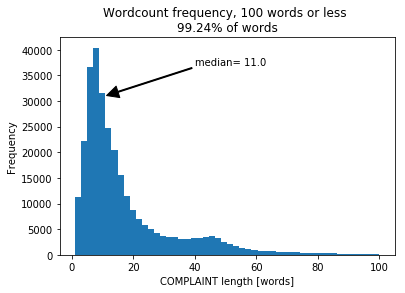

In [51]:
plt.hist(wordcount[wordcount.apply(lambda x: x<=100)],bins=50)
plt.title('Wordcount frequency, 100 words or less \n'+ str( round(1-(2259/296103),4)*100 )+ '% of words')
plt.ylabel('Frequency')
plt.xlabel('COMPLAINT length [words]')
plt.annotate('median= '+str(np.median(wordcount[wordcount.apply(lambda x: x<=100)])), xy=(11, 31000), xytext=(40, 37000),
            arrowprops=dict(facecolor='black', shrink=0.01,width=1),
            )
plt.show()

In [41]:
np.median(wordcount[wordcount.apply(lambda x: x<=100)])

11.0

In [53]:
sum(wordcount.apply(lambda x: x<=1))

5394

In [64]:
chi_br_IE_train_1[chi_br_IE_train_1['WORDCOUNT']==1].groupby(['COMPLAINT']).count().sort_values('COMPLAINT_ID', ascending=False)\
.head(20)

,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,WORDCOUNT
COMPLAINT,,,,
B/U,2283,2283,2283,2283
B/U-,806,806,806,806
O/F,472,472,472,472
L/P,266,266,266,266
S/O,170,170,170,170
TV,137,137,137,137
O/F-,119,119,119,119
BACK-UP,104,104,104,104
"Hi,",94,94,94,94


In [65]:
chi_br_IE_train_1[chi_br_IE_train_1['WORDCOUNT']==2].groupby(['COMPLAINT']).count().sort_values('COMPLAINT_ID', ascending=False)\
.head(20)

,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,WORDCOUNT
COMPLAINT,,,,
NEW CART,941,941,941,941
REQUEST CART,273,273,273,273
IN FLASH,234,234,234,234
REPLACE LID,166,166,166,166
SIGNAL OUT,166,166,166,166
HIGH WATER,126,126,126,126
Please repair,94,94,94,94
LID MISSING,93,93,93,93
RESIDENTIAL AREA,64,64,64,64


In [66]:
chi_br_IE_train_1[chi_br_IE_train_1['WORDCOUNT']==3].groupby(['COMPLAINT']).count().sort_values('COMPLAINT_ID', ascending=False)\
.head(20)

,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,WORDCOUNT
COMPLAINT,,,,
REQUEST RECYCLE CART,1008,1008,1008,1008
NEW RECYCLE CART,934,934,934,934
RECYCLE CART NEEDED,483,483,483,483
WAZE USER REPORTED,267,267,267,267
STOP SIGN DOWN,124,124,124,124
ABANDONED PROPERTY MOWING,117,117,117,117
MISSED SERVICE TODAY,95,95,95,95
REQUEST 96 GAL,88,88,88,88
"CART CRACKED, REPLACE",68,68,68,68


In [69]:
display(chi_br_IE_train_1[chi_br_IE_train_1['COMPLAINT']=='B/U'].head(1))
chi_br_IE_train_1[chi_br_IE_train_1['COMPLAINT']=='B/U'].groupby('CATEGORY_SUB').count().head(2)

,COMPLAINT_ID,CATEGORY_MAIN,CATEGORY_SUB,COMPLAINT,WORDCOUNT
48218,US_BATON_ROUGE_376069,INFRASTRUCTURE,INFRASTRUCTURE_GENERAL,B/U,1


,COMPLAINT_ID,CATEGORY_MAIN,COMPLAINT,WORDCOUNT
CATEGORY_SUB,,,,
INFRASTRUCTURE_GENERAL,2280,2280,2280,2280
INFRASTRUCTURE_WATER_REPAIR,2,2,2,2


*NOTES*
- May want to pre-process, eliminate common useless words like "hi", "B/U", or other codes
- May not need to eliminate these if they are not biased to one category or if "B/U" code is not used in practice

# APPENDIX OF SCRATCH WORK

In [105]:

reclass_dict=defaultdict(list)


for index,row in df_reclass.iterrows():
    
    # add new city or append to city
    # add or append Department class with 311 sub category
    # get the new MAIN and SUB classes
    
    reclass_dict[row['CITY']].append({\
        row['DEPT_311']:{row['CODE_311']:\
                         {'CATEGORY_MAIN': row['CATEGORY_MAIN'],'CATEGORY_SUB':row['CATEGORY_SUB']}}})  

    
reclass_dict 

defaultdict(list,
            {'US_BATON_ROUGE': [{'BLIGHTED PROPERTIES': {'DIRTY OR UNFENCED SWIMMING POOL': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_SAFETY'}}},
              {'BLIGHTED PROPERTIES': {'ILLEGAL SIGN IN THE PUBLIC RIGHT-OF-WAY': {'CATEGORY_MAIN': 'GOVERNANCE',
                 'CATEGORY_SUB': 'GOVERNANCE_SIGNAGE'}}},
              {'BLIGHTED PROPERTIES': {'JUNK, INOPERABLE, OR ABANDONED VEHICLE': {'CATEGORY_MAIN': 'ENVIRONMENT',
                 'CATEGORY_SUB': 'ENVIRONMENT_ABANDONED_VEHICLE'}}},
              {'BLIGHTED PROPERTIES': {'JUNK, TRASH, OR DEBRIS ON PRIVATE PROPERTY': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_HEALTH_CODE'}}},
              {'BLIGHTED PROPERTIES': {'PROPERTY MISSING WINDOWS OR DOORS': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_GENERAL'}}},
              {'BLIGHTED PROPERTIES': {'PROPERTY NEEDS TO BE CONDEMNED OR TORN DOWN': {'CATEGORY_MAIN': 'ENVIRONMENT',


In [142]:
reclass_dict=defaultdict(dict)


for index,row in df_reclass.iterrows():
    
    # add new city or append to city
    # add or append Department class with 311 sub category
    # get the new MAIN and SUB classes
    dummy_dict={'CATEGORY_MAIN': row['CATEGORY_MAIN'],'CATEGORY_SUB':row['CATEGORY_SUB']}
    reclass_dict.update({row['CITY']:{row['DEPT_311']:{row['CODE_311']:dummy_dict}}})  

    
reclass_dict 

defaultdict(dict,
            {'US_BATON_ROUGE': {'STREET/TRAFFIC ISSUES': {'SCHOOL ZONE/SCHOOL FLASHER ISSUE': {'CATEGORY_MAIN': 'GOVERNANCE',
                'CATEGORY_SUB': 'GOVERNANCE_SIGNAGE'}}},
             'US_CHICAGO': {'health_environment': {'other': {'CATEGORY_MAIN': 'ENVIRONMENT',
                'CATEGORY_SUB': 'ENVIRONMENT_GENERAL'}}}})

In [146]:
df_reclass.groupby(['CITY','DEPT_311','CODE_311']).apply(lambda x: [dict(zip(x.CATEGORY_MAIN, x.CATEGORY_SUB))]).to_dict()

{('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'DIRTY OR UNFENCED SWIMMING POOL'): [{'HOUSING': 'HOUSING_SAFETY'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'ILLEGAL SIGN IN THE PUBLIC RIGHT-OF-WAY'): [{'GOVERNANCE': 'GOVERNANCE_SIGNAGE'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'JUNK, INOPERABLE, OR ABANDONED VEHICLE'): [{'ENVIRONMENT': 'ENVIRONMENT_ABANDONED_VEHICLE'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'JUNK, TRASH, OR DEBRIS ON PRIVATE PROPERTY'): [{'HOUSING': 'HOUSING_HEALTH_CODE'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'PROPERTY MISSING WINDOWS OR DOORS'): [{'HOUSING': 'HOUSING_GENERAL'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'PROPERTY NEEDS TO BE CONDEMNED OR TORN DOWN'): [{'ENVIRONMENT': 'ENVIRONMENT_ABANDONED_SITE'}],
 ('US_BATON_ROUGE',
  'BLIGHTED PROPERTIES',
  'TALL GRASS'): [{'ENVIRONMENT': 'ENVIRONMENT_OVERGROWTH'}],
 ('US_BATON_ROUGE',
  'CODE VIOLATIONS',
  'BUILDING CODE VIOLATIONS'): [{'PLANNING': 'PLANNING_UNSAFE_ENVIRO

In [177]:
dummy=defaultdict(dict)

dummy[('US_CHICAGO','health_environment','other')]=('a','b')
dummy[('US_CHICAGO','health_environment','service stations/storage tanks work order')]=('a','c')

display(dummy)
display(dummy[('US_CHICAGO','health_environment','other')])
display(dummy.get(('US_CHICAGO','health_environment','service stations/storage tanks work order'))[1])
#display(dummy.get(('US_CHICAGO','health_environment','recycling work order'))[1])

defaultdict(dict,
            {('US_CHICAGO', 'health_environment', 'other'): ('a', 'b'),
             ('US_CHICAGO',
              'health_environment',
              'service stations/storage tanks work order'): ('a', 'c')})

('a', 'b')

'c'

In [185]:
def lookup_311_code(dic,city,dept_311,code_311):
    
    vals=dic.get((city,dept_311,code_311))
    
    if vals is not None:
        return vals
    else:
        return ('unknown','unknown')
    


lookup_311_code(dummy,'US_CHICAGO','health_environment','other')[0]

'a'

In [115]:

reclass_dictlist=list()


for index,row in df_reclass.iterrows():
    
    # add new city or append to city
    # add or append Department class with 311 sub category
    # get the new MAIN and SUB classes
    
    reclass_dictlist.append({row['CITY']:\
        {row['DEPT_311']:{row['CODE_311']:\
        {'CATEGORY_MAIN': row['CATEGORY_MAIN'],'CATEGORY_SUB':row['CATEGORY_SUB']}}}})  

    
reclass_dict 

defaultdict(list,
            {'US_BATON_ROUGE': [{'BLIGHTED PROPERTIES': {'DIRTY OR UNFENCED SWIMMING POOL': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_SAFETY'}}},
              {'BLIGHTED PROPERTIES': {'ILLEGAL SIGN IN THE PUBLIC RIGHT-OF-WAY': {'CATEGORY_MAIN': 'GOVERNANCE',
                 'CATEGORY_SUB': 'GOVERNANCE_SIGNAGE'}}},
              {'BLIGHTED PROPERTIES': {'JUNK, INOPERABLE, OR ABANDONED VEHICLE': {'CATEGORY_MAIN': 'ENVIRONMENT',
                 'CATEGORY_SUB': 'ENVIRONMENT_ABANDONED_VEHICLE'}}},
              {'BLIGHTED PROPERTIES': {'JUNK, TRASH, OR DEBRIS ON PRIVATE PROPERTY': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_HEALTH_CODE'}}},
              {'BLIGHTED PROPERTIES': {'PROPERTY MISSING WINDOWS OR DOORS': {'CATEGORY_MAIN': 'HOUSING',
                 'CATEGORY_SUB': 'HOUSING_GENERAL'}}},
              {'BLIGHTED PROPERTIES': {'PROPERTY NEEDS TO BE CONDEMNED OR TORN DOWN': {'CATEGORY_MAIN': 'ENVIRONMENT',


In [118]:
reclass_dictlist[0]
reclass_dictlist.index(['US_CHICAGO']['health_environment']['abandoned site'])

TypeError: list indices must be integers or slices, not str

In [102]:

reclass_dict=dict()


for index,row in df_reclass.iterrows():
    
    # add new city or append to city
    # add or append Department class with 311 sub category
    # get the new MAIN and SUB classes
    
    reclass_dict=dict(reclass_dict,**{row['CITY']:{
        row['DEPT_311']:{row['CODE_311']:\
                         {'CATEGORY_MAIN': row['CATEGORY_MAIN'],'CATEGORY_SUB':row['CATEGORY_SUB']}}}}  )

    
reclass_dict 

{'US_BATON_ROUGE': {'STREET/TRAFFIC ISSUES': {'SCHOOL ZONE/SCHOOL FLASHER ISSUE': {'CATEGORY_MAIN': 'GOVERNANCE',
    'CATEGORY_SUB': 'GOVERNANCE_SIGNAGE'}}},
 'US_CHICAGO': {'health_environment': {'other': {'CATEGORY_MAIN': 'ENVIRONMENT',
    'CATEGORY_SUB': 'ENVIRONMENT_GENERAL'}}}}

In [90]:
from collections import Counter
reclass_dict=dict()


for index,row in df_reclass.iterrows():
    
    # add new city or append to city
    # add or append Department class with 311 sub category
    # get the new MAIN and SUB classes
    dummydict={'CATEGORY_MAIN': row['CATEGORY_MAIN'],'CATEGORY_SUB':row['CATEGORY_SUB']}
    reclass_dict+={row['CITY']:{row['DEPT_311']:{row['CODE_311']}}}
    

    
reclass_dict 

TypeError: unsupported operand type(s) for +=: 'dict' and 'dict'